# CISC 372: Advanced Data Analytics

## Exploratory Data Analysis

__Udbhav Balaji__

20179467

In [1]:
# importing the necessary libraries
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

/opt/anaconda3/envs/spotify/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Reading in the 3 datasets
data_90s = pd.read_csv('Datasets/dataset-of-90s.csv')
data_00s = pd.read_csv('Datasets/dataset-of-10s.csv')
data_10s = pd.read_csv('Datasets/dataset-of-10s.csv')

In [3]:
# Since all the 3 datasets have the same columns, we can simply concatenate them together in order to create a master dataset
master_data = pd.concat([data_90s, data_00s, data_10s], ignore_index=True, axis=0)

# In order to avoid any bias due to time period, let's shuffle the rows so that their order is random
master_data = shuffle(master_data)
master_data.reset_index(inplace=True, drop=True)

In [4]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             18316 non-null  object 
 1   artist            18316 non-null  object 
 2   uri               18316 non-null  object 
 3   danceability      18316 non-null  float64
 4   energy            18316 non-null  float64
 5   key               18316 non-null  int64  
 6   loudness          18316 non-null  float64
 7   mode              18316 non-null  int64  
 8   speechiness       18316 non-null  float64
 9   acousticness      18316 non-null  float64
 10  instrumentalness  18316 non-null  float64
 11  liveness          18316 non-null  float64
 12  valence           18316 non-null  float64
 13  tempo             18316 non-null  float64
 14  duration_ms       18316 non-null  int64  
 15  time_signature    18316 non-null  int64  
 16  chorus_hit        18316 non-null  float6

Now, let us further explore the correlation between each of these features with respect to the target

In [5]:
master_data.groupby('target').danceability.mean()

target
0    0.491776
1    0.643784
Name: danceability, dtype: float64

We see that hit songs have a higher average danceability metric.

In [6]:
group_df = master_data.groupby('key').target.value_counts()
group_df

key  target
0    0         1082
     1          994
1    1         1130
     0          863
2    0          967
     1          764
3    0          333
     1          253
4    0          734
     1          593
5    0          779
     1          724
6    1          767
     0          632
7    0         1078
     1          995
8    1          708
     0          495
9    0          919
     1          764
10   1          666
     0          548
11   1          800
     0          728
Name: target, dtype: int64

In [7]:
df_list = []
for index, row in group_df.items():
    df_list.append([index[0], index[1], row])

grouped = pd.DataFrame(df_list)
grouped.columns = ['key','target','num_songs']
grouped

,key,target,num_songs
0,0,0,1082
1,0,1,994
2,1,1,1130
3,1,0,863
4,2,0,967
5,2,1,764
6,3,0,333
7,3,1,253
8,4,0,734
9,4,1,593


<Figure size 2880x1440 with 0 Axes>

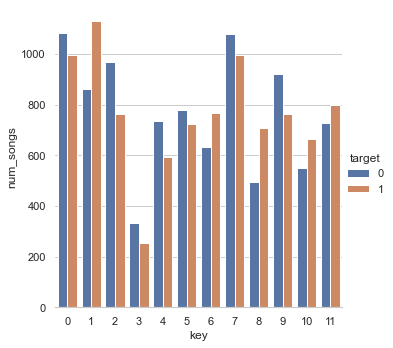

In [8]:
fig = plt.figure(figsize=(40,20))
sns.set_theme(style='whitegrid')
g = sns.catplot(x='key', y='num_songs', hue='target', data=grouped, kind='bar')
g.despine(left=True)
plt.show()

We can see that the keys that had more hit songs than flop songs are C#, F#, G#, A# and B. Thus, making a song in one of these keys would help make the song a hit.

In [9]:
group_df = master_data.groupby('mode').target.value_counts()
df_list = []
for index, row in group_df.items():
    df_list.append([index[0], index[1], row])

grouped = pd.DataFrame(df_list)
grouped.columns = ['mode','target','num_songs']

<Figure size 2880x1440 with 0 Axes>

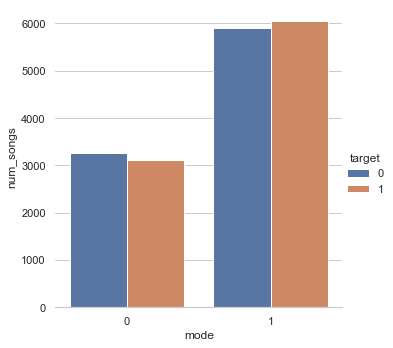

In [10]:
fig = plt.figure(figsize=(40,20))
sns.set_theme(style='whitegrid')
g = sns.catplot(x='mode', y='num_songs', hue='target', data=grouped, kind='bar')
g.despine(left=True)
plt.show()

Here, we can see that there are more tracks that have a major key, while the distribution of hit and flop songs are quite equal for both the major and minor key tracks.

In [11]:
master_data.groupby('target').tempo.mean()

target
0    120.788648
1    121.801358
Name: tempo, dtype: float64

Here, we see that the average tempo of a song is around 120 BPM. Howeever, there is no significant difference based on hit/flop songs.

In [12]:
master_data.groupby('target').duration_ms.mean()

target
0    251630.322123
1    233535.845490
Name: duration_ms, dtype: float64

There is quite a significant difference in the duration of hit and flop songs, that can be seen in the table above.

In [13]:
master_data.groupby('target').instrumentalness.mean()

target
0    0.314110
1    0.013217
Name: instrumentalness, dtype: float64

We can see that there is very significant difference in the instrumentalness of a track between the hits and flop songs. Hit songs have more vocals and lesser instrumnetalness. 

In [14]:
master_data.groupby('target').chorus_hit.mean()

target
0    42.485120
1    39.554173
Name: chorus_hit, dtype: float64

We can also see that on average, the hit songs have their hooks/chorus about 3 seconds earlier than the flop songs. 

Based on our findings, we can say that, to make a hit song, having the following features couls help it become a hit:

1. High danceability
2. Has a key of either C#, F#, G#, A# or B
3. Be quite short in length
4. Have a low instrumentalness score
5. Have it's hook/chorus hit around 39 seconds into the song